# Автоматизация подбора цены исходя из эластичности спроса
подготовил: [Вова Сизов](mailto:vladimirsizov@yandex.ru)
<hr>

При работе с ценой на маркетплейсе я столкнулся с необходимостью подбора оптимальной цены.  
Задача заключалась в том чтобы сэкономить время не выполняя однотипные операции ежедневного пересчёта цены исходя из её эластичности.
Также стоял небольшой вопрос сколько и каких жанных нужно чтобы начать прогнозировать оптимальную цену.

### Вводные данные

Существует множество параметров по которым продавец определяет какую цену для клиента устанавливать?  
Здесь я не буду учитывать такие факторы как реклама или участие в акции, стоимость комиссий и прочее по отдельности, всё это можно считать по данным последних продаж и поместить в условную переменную - себестоимость товара.

Так как продажи это про прибыль мы оставим и этот параметр, а из суммы расходов и прибыли у нас образуется цена товара для потребителя.  

### Эластичность спроса

Это такой показатель который говорит нам о зависимости количества продаж от цены товара.  
Чем дешевле продаётся товар тем меньше мы зарабатываем с единицы товара.  
При этом мы знаем что чем дешевле мы продаём товар тем больше едениц товара можно продать.  

Показателем эффективности продаж в первую очередь является прибыль - маржа помноженая на количество проданных товаров.  
Зная при каждой цене товара количество продаж мы можем посчитать прибыль при каждой цене, а зная прибыль для каждой цены мы можем выбрать лучшую цену с точки зрения извлечения прибыли.  
При этом если мы получаем одинаковую прибыль при разном количестве продаж мы можем выбрать цену где мы больше продаём.

<hr>

Импортируем библиотеки с которыми будем работать

In [1055]:
import pandas as pd
import numpy as np
import scipy
import random

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

import warnings
warnings.filterwarnings(action='ignore')

Для начала мы создадим набор данных для гипотетического товара за определённый период.  
Чтобы расчёт был честным нужно учесть что для каждой уникальной цены по которой были продажи количество дней было примерно одинаковым.
Здесь я буду использовать уже как бы агригированные данные коотрые нам покажут зависимость продаж от цены.

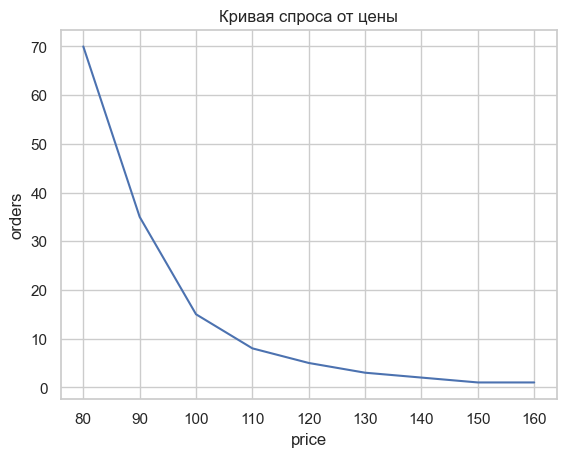

In [1056]:
# кривая спроса
gen_data = pd.DataFrame(data=[[70, 80], [35, 90], [15, 100], [8, 110], [5, 120], [3, 130], [2, 140], 
                              [1, 150], [1, 160]], columns=['orders', 'price'])

sns.lineplot(gen_data, x='price', y='orders')
plt.title('Кривая спроса от цены')
plt.show();

В качестве себестоимости товара мы определим переменную cost_price

In [1057]:
# себестоимость товара
cost_price = 80

Функция get_elast  

Возвращает:
- оптимальную цену исходя из прибыли и объёма продаж и размер прибыли
- таблицу с сглаженными данными (необходимо при недостатке данных или сильной зашумленности)
- Графики 'Кривая спроса от цены', 'Кривая прибыли от цены'

Принимает:
- датафрейм с колонками ['orders', 'price']
- себестоимость товарной единицы
- указывая параметр smoth > 0 мы определяем степень сглаживаемости кривой спроса, это даёт значительный эффект при малых объёмах данных
- chart определяет хотим ли мы визуализировать данные в графиках
- return_data сообщает о том что мы хотим получить не оптимальную цену и размер прибыли а датафрейм со всеми данными

Функция получает данные за определённый период продаж и группирует их по одинаковой цене.  
Для того чтобы опредилить оптимальную цену - уникальных цен должно быть не менее трёх, в идеале пяти.  
При этом количество продаж должно быть более чем количество уникальных цен.  

Затем считается прибыль для каждой цены и находится цена с максимальной прибылью.
При наличии нескольких мод по прибыли цена выбирается с максимальным количеством продаж.

В конце рисуются графики.

Если мы используем сглаживание то из набора аггрегированных данных определяется диапазон из 100 различных цен между минимальной и максимальной.  
Затем определяется показатель значения количества заказов методом интерполяции, и применяем сглаживание.  
В этом случае расчёт оптимальной цены идёт не из исходных данных а сглаженых.

In [1058]:
def get_elast(df, cost_price, smoth=0, chart=True, show_data=True, return_data=False):
    '''получение кривой спроса от прибыли и цены, а также оптимальной цены с приоритетом максимальной прибыли и количества продаж'''
    # Названия колонок входных данных должны быть ['orders', 'price']
    columns = df.columns.tolist()
    if columns == ['orders', 'price']:
        df = df.groupby('price').agg({'orders': sum}).reset_index()
        
        # Уникальных цен в колонке 'price' должнобыть больше 2, а число заказов должно быть больше числа уникальных цен.
        if (len(df) > 2) & (df.orders.sum() > (len(df))):
            df_copy = df.copy()
            if smoth > 0:
                # получим исходные значения
                # увеличим количество данных о ценах в 2 раза
                new_price = np.linspace(df.price.min(), df.price.max(), 100)
                # сделаем линейную интерполяцию для orders
                orders_interp = scipy.interpolate.interp1d(df.price, df.orders)
                new_orders = [orders_interp(i).tolist() for i in new_price]
                # сгладим значения
                Y = np.polyval(np.polyfit(new_price, new_orders, smoth), new_price)
                df = pd.DataFrame({'price': new_price, 'orders': Y})
                
            df['profit'] = (df.price - cost_price) * df.orders
            
            if show_data:
                display(df)

            # найдём максимальное значение прибыли
            max_profit = df.profit.max()
            # определяем цену для максимальной прибыли
            max_profit_price = df[df.profit == max_profit].price
            # при одинаковой прибыли выбираем ту цену где больше продаж
            if len(max_profit_price)> 1:
                max_profit_orders = df[df.profit == max_profit].orders.max()
                max_profit_price = df[(df.profit == max_profit) & (df.orders == max_profit_orders)].price.values[0]
            else:
                max_profit_price = df[df.profit == max_profit].price.values[0]
            
            # нарисуем графики
            if chart:
                # нарисуем графики
                sns.lineplot(df_copy, x='price', y='orders')
                sns.lineplot(df, x='price', y='orders')
                plt.legend(['исходные данные', 'усреднённые данные']);
                plt.title('Кривая спроса от цены')
                plt.show();
                sns.lineplot(df, x='price', y='profit')
                plt.scatter(max_profit_price, max_profit, color='red')
                plt.title('Кривая прибыли от цены')
                plt.show();
            
            if return_data:
                return df
            else:
                return [max_profit_price, max_profit]
 
        else:
            print("Уникальных цен в колонке 'price' должнобыть больше 2", 
                  "\nЧисло заказов должно быть больше числа уникальных цен.")
    else:
        print("Названия колонок входных данных должны быть ['orders', 'price']")

Данные из 9 строк которые мы сгенерировали в переменную df можно преобразовать в 100 строк.  

Ниже находится датафрем со сглаженными данными, а также два графика:  
- кривая спроса от цены (синий - исходные данные, оранжевый - сглаженные)
- кривая прибыли от цены (красная точка - значение максимальной прибыли)  

В самом низу список [оптимальная_цена, размер_прибыли_при_этой цене]

,price,orders,profit
0,80.000000,70.052852,0.000000
1,80.808081,67.260479,54.351902
2,81.616162,64.393419,104.070172
3,82.424242,61.484797,149.054054
4,83.232323,58.563516,189.296215
...,...,...,...
95,156.767677,0.938166,72.020861
96,157.575758,0.955196,74.100026
97,158.383838,0.983965,77.126981
98,159.191919,1.025297,81.195276


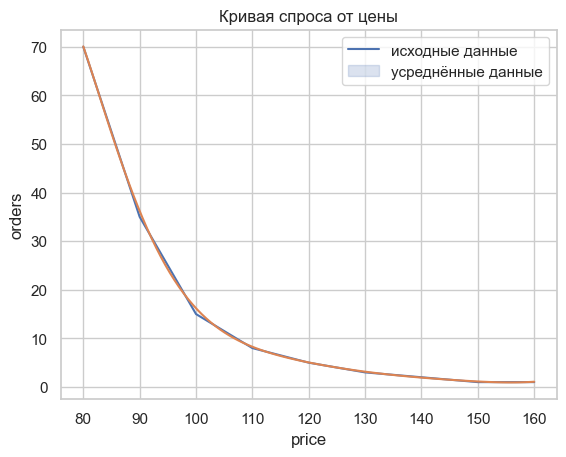

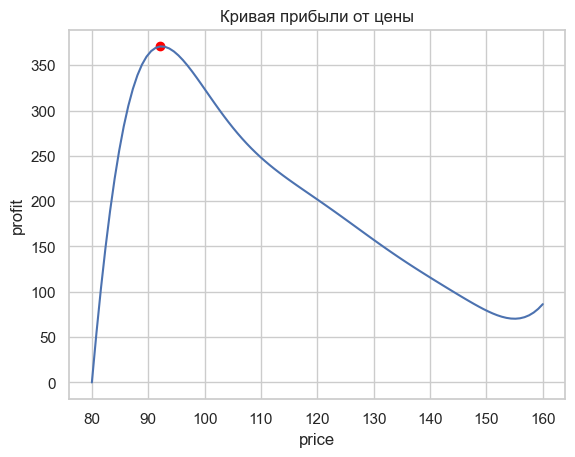

[92.12121212121212, 370.7090110544497]

In [1059]:
get_elast(gen_data, cost_price, smoth=8)

<hr>

Предположим что мы только только зашли на рынок с нашим товаром, и мы не знаем кривой спроса на этот товар.  

Мы знаем цену ниже которой мы не станем опускатся (cost_price - себестоимость)  
Еще мы определили среднюю цену продаж аналогичного товара в товарной нише равную 115, хотя можем начать с более дикой цены например 150 (посмотрим как это скажется на подборе)
Этого нам будет достаточно, чтобы сначала прощупать рынок на продажи в этом диапазоне, мы выделим на это от 3 до 5 дней, может больше в зависимости от наличия продаж.

In [1060]:
# цена с которой мы начнём
normal_price = 150

<hr>

Создадим датафрейм с элстичностью спроса на наш товар. Отсюда мы будем брать данные о результатах наших будущих продаж.  
Помним что на самом деле мы как бы пока ещё не знаем этих данных. 

In [1061]:
# датафрейм эластичности спроса 
df = get_elast(gen_data, cost_price, smoth=8, chart=False, show_data=False, return_data=True)
df#.head()

,price,orders,profit
0,80.000000,70.052852,0.000000
1,80.808081,67.260479,54.351902
2,81.616162,64.393419,104.070172
3,82.424242,61.484797,149.054054
4,83.232323,58.563516,189.296215
...,...,...,...
95,156.767677,0.938166,72.020861
96,157.575758,0.955196,74.100026
97,158.383838,0.983965,77.126981
98,159.191919,1.025297,81.195276


Чтобы жизнь нам не казалась одной малиной при запросе к этим данным мы также будем вносить шум относительно получаемых данных размера продаж к цене, так как продажи день на день не приходятся одинаковыми.

Наш эксперимент будет длится 21 день

In [1062]:
# дата начала эксперимента
date_start = pd.to_datetime('2023-08-05')

# дней эксперимента
days = 21

Так как первые дни у нас будет недостаточно данных для кривой спроса мы будем каждый день работать с новой ценой из списка list_prices 

Среднюю цену продаж аналогичного товара в товарной нише определили в переменную normal_price

last_ind_list_prices нам понадобится при работе с функцией get_primary_price

In [1063]:
# последняя использованная цена из списка цен для первичного тестирования эластичности
last_ind_list_prices = 0

# создаём список цен для первичного тестирования эластичности
list_prices = [normal_price * 2 - cost_price, 
               (normal_price + cost_price) / 2,
               (normal_price * 3 - cost_price) / 2,
               cost_price,
               normal_price]
list_prices

[220, 115.0, 185.0, 80, 150]

Ниже представлены функции к которым будет обращатся наш алгоритм:
- get_last_orders возвращает датафрейм данных о последних продажах за указанное в last_days количестве дней
- get_premission_elasticity сообщает достаточно ли у нас собрано данных для использования функции прогноза эластичности спроса
- get_count_orders возвращает количество заказов при определённой цене из исходных данных, причем получаемые результаты будут с шумом +/- 20% от данных из таблицы df
- get_primary_price возврщает цену при первичном тестировании цен

In [1064]:
def get_last_orders(df, last_days=7):
    '''получаем заказы за последние (указанное количество) дней'''
    try:
        return df[(df.date > df.date.max() - pd.Timedelta(days=last_days)) & (df.date <= df.date.max())]
    except:
        return df

In [1065]:
def get_premission_elasticity(df):
    '''получить разрешение построить кривую спроса'''
    data = df.groupby('price').agg({'orders': 'mean'}).reset_index()
    # если уникальных цен в колонке 'price' должнобыть больше 4", а число заказов должно быть больше числа уникальных цен.
    if (len(data) > 4) & (data.orders.sum() > len(data)):
        return True
    else:
        return False

In [1066]:
def get_count_orders(df, price):
    '''возвращает количество заказов из исходных данных'''
    for i in range(len(df)):
        # проверяем есть ли такая цена в данных, иначе берём предельные
        if price < df.price.min():
            return df.orders.max()
        elif price > df.price.max():
            return df.orders.min()
        else:
            # если текущая цена меньше искомой цены
            if df.loc[i].price < price:
                continue
            # если текущая цена больше
            else:
                # внесём немного случайности в количество заказов
                orders = int(random.uniform(df.loc[i].orders*0.8, df.loc[i].orders*1.2))
                orders = df.loc[i].orders
                return orders

In [1067]:
def get_primary_price(list_prices, last_ind_list_prices):
    '''получаем цену из списка цен для первичного тестирования эластичности'''
    price = list_prices[last_ind_list_prices]
    if last_ind_list_prices < (len(list_prices) - 1):
        last_ind_list_prices += 1
    else:
        last_ind_list_prices = 0
    return [price, last_ind_list_prices]

Непосредственно здесь мы будем имитировать продажи и подбор оптимальной цены на двух кадрах данных за предыдущие 7 и 14 дней, и брать их среднее арифметическое.  

При каждой итерации мы будем показывать тот кадр данных с которыми работаем в этот день, а также построим графики кривых спроса и прибыли.  

Порядок:
- получаем данные предыдущего периода
- выясняем достаточно ли данных для рассчёта оптимальной цены.
- считаем оптимальную цену если данных достаточно,  
если данных не достаточно берём цену из списка list_prices
- рисуем графики
- записываем данные текущего дня в data

Помним что лучшая цена 92.12  

Внимание!  
Сейчас будет много данных, поехали:

сегодня: 2023-08-05 
данные предыдущего периода:


,date,orders,price,profit,elasticity


данных для расчёта оптимальной цены НЕ достаточно

--------------------------

сегодня: 2023-08-06 
данные предыдущего периода:


,date,orders,price,profit,elasticity
0,2023-08-05,0,220,130.48,False


данных для расчёта оптимальной цены НЕ достаточно

--------------------------

сегодня: 2023-08-07 
данные предыдущего периода:


,date,orders,price,profit,elasticity
0,2023-08-05,0,220.0,130.48,False
1,2023-08-06,6,115.0,217.54,False


данных для расчёта оптимальной цены НЕ достаточно

--------------------------

сегодня: 2023-08-08 
данные предыдущего периода:


,date,orders,price,profit,elasticity
0,2023-08-05,0,220.0,130.48,False
1,2023-08-06,6,115.0,217.54,False
2,2023-08-07,0,185.0,97.86,False


данных для расчёта оптимальной цены НЕ достаточно

--------------------------

сегодня: 2023-08-09 
данные предыдущего периода:


,date,orders,price,profit,elasticity
0,2023-08-05,0,220.0,130.48,False
1,2023-08-06,6,115.0,217.54,False
2,2023-08-07,0,185.0,97.86,False
3,2023-08-08,70,80.0,0.00,False


данных для расчёта оптимальной цены НЕ достаточно

--------------------------

сегодня: 2023-08-10 
данные предыдущего периода:


,date,orders,price,profit,elasticity
0,2023-08-05,0,220.0,130.48,False
1,2023-08-06,6,115.0,217.54,False
2,2023-08-07,0,185.0,97.86,False
3,2023-08-08,70,80.0,0.00,False
4,2023-08-09,1,150.0,78.08,False


считаем оптимальную цену 7 дней


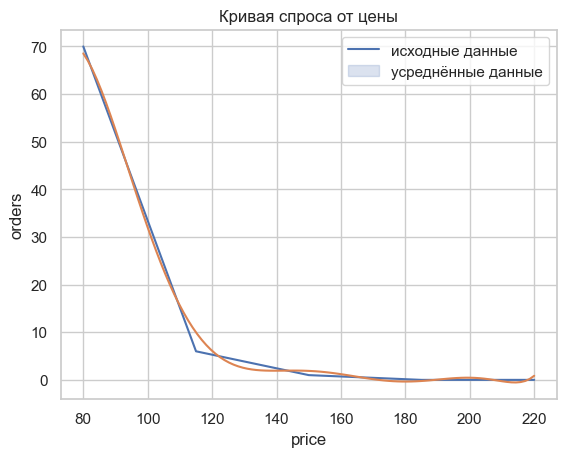

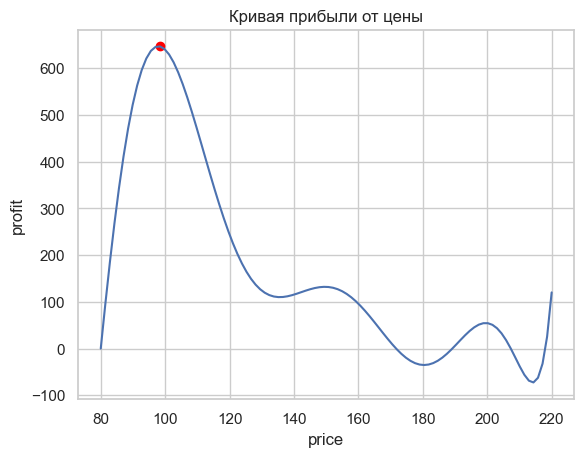

считаем оптимальную цену 14 дней


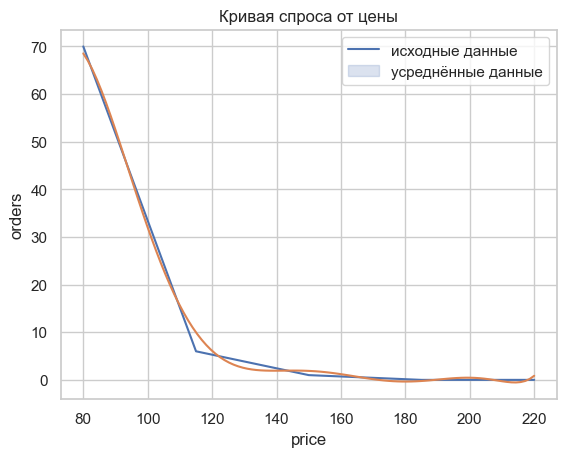

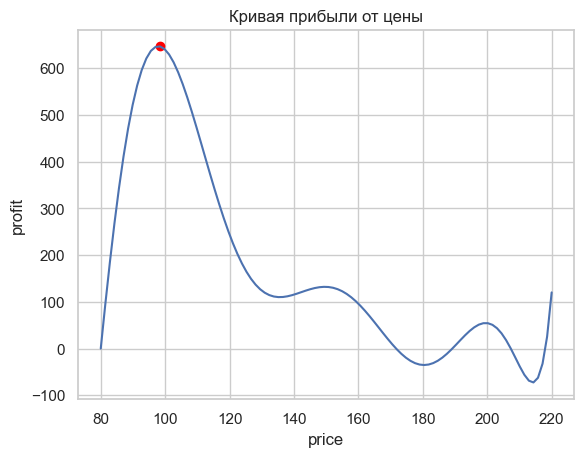


--------------------------

сегодня: 2023-08-11 
данные предыдущего периода:


,date,orders,price,profit,elasticity
0,2023-08-05,0,220.00,130.48,False
1,2023-08-06,6,115.00,217.54,False
2,2023-08-07,0,185.00,97.86,False
3,2023-08-08,70,80.00,0.00,False
4,2023-08-09,1,150.00,78.08,False
5,2023-08-10,20,96.69,343.92,True


считаем оптимальную цену 7 дней


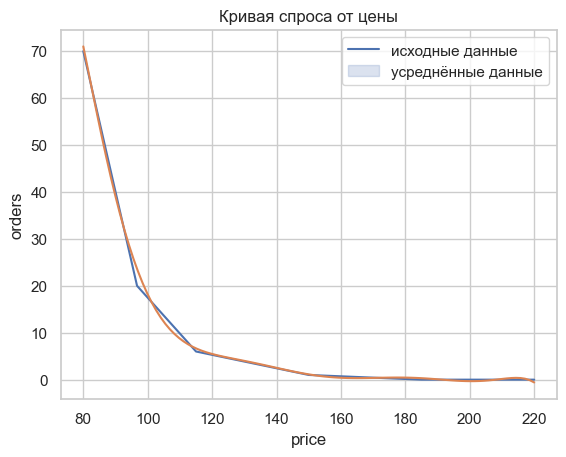

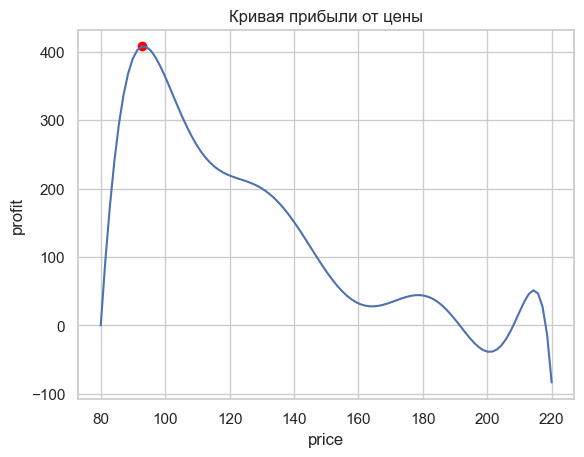

считаем оптимальную цену 14 дней


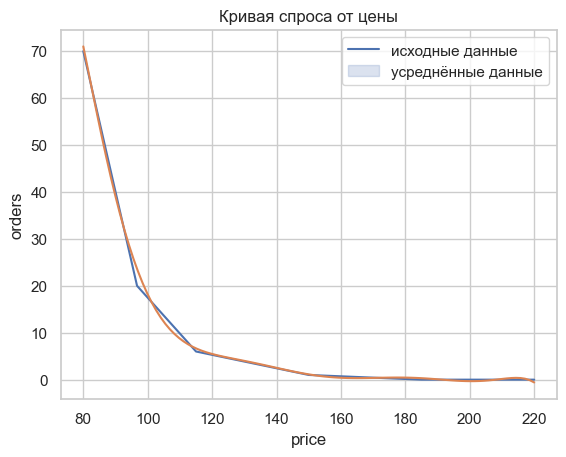

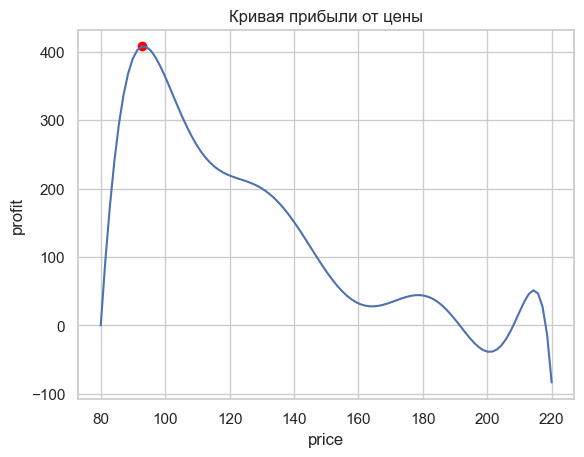


--------------------------

сегодня: 2023-08-12 
данные предыдущего периода:


,date,orders,price,profit,elasticity
0,2023-08-05,0,220.00,130.48,False
1,2023-08-06,6,115.00,217.54,False
2,2023-08-07,0,185.00,97.86,False
3,2023-08-08,70,80.00,0.00,False
4,2023-08-09,1,150.00,78.08,False
5,2023-08-10,20,96.69,343.92,True
6,2023-08-11,25,94.07,353.39,True


считаем оптимальную цену 7 дней


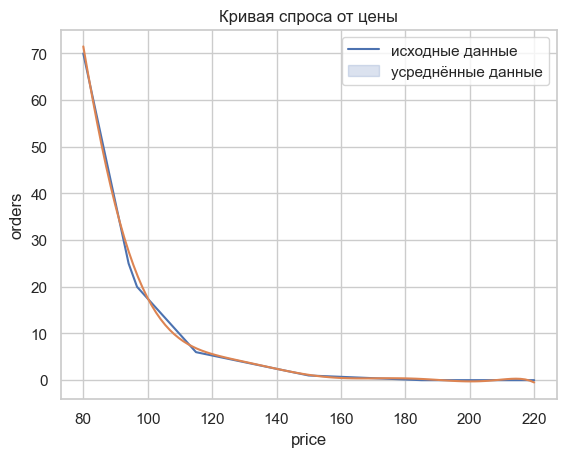

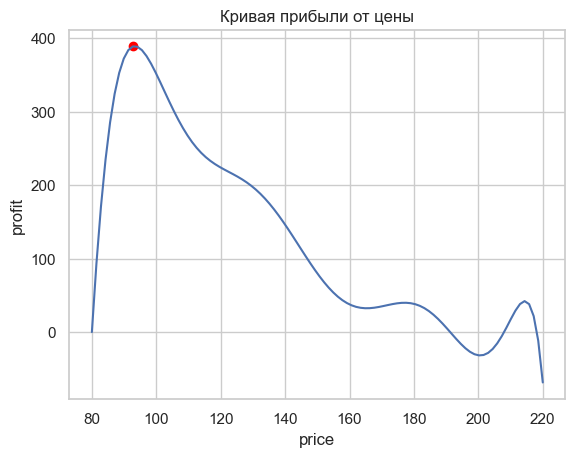

считаем оптимальную цену 14 дней


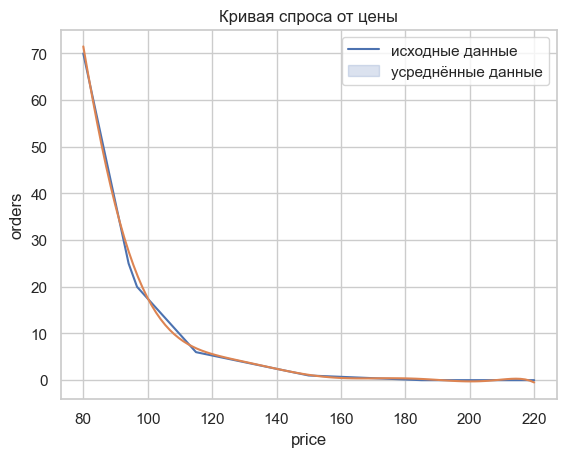

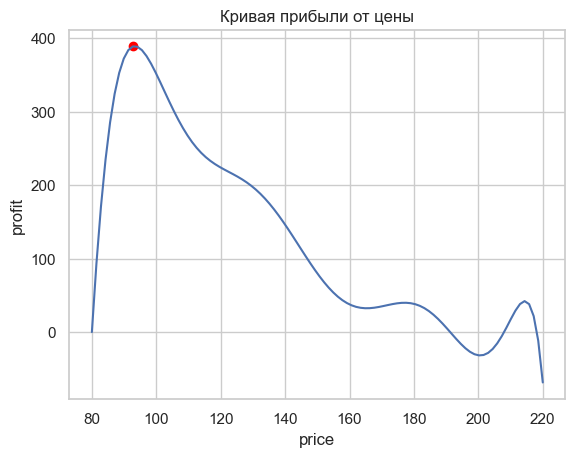


--------------------------

сегодня: 2023-08-13 
данные предыдущего периода:


,date,orders,price,profit,elasticity
1,2023-08-06,6,115.00,217.54,False
2,2023-08-07,0,185.00,97.86,False
3,2023-08-08,70,80.00,0.00,False
4,2023-08-09,1,150.00,78.08,False
5,2023-08-10,20,96.69,343.92,True
6,2023-08-11,25,94.07,353.39,True
7,2023-08-12,32,90.89,355.51,True


считаем оптимальную цену 7 дней


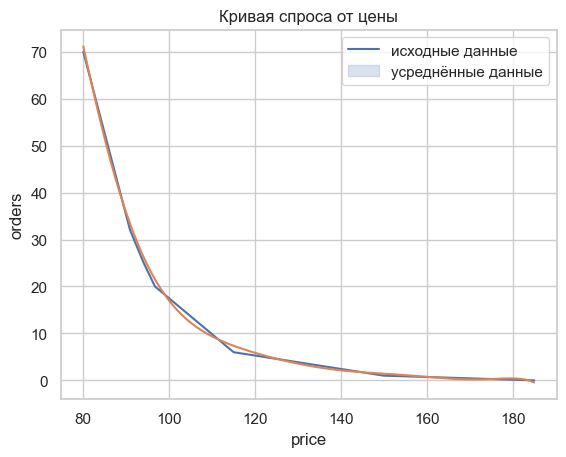

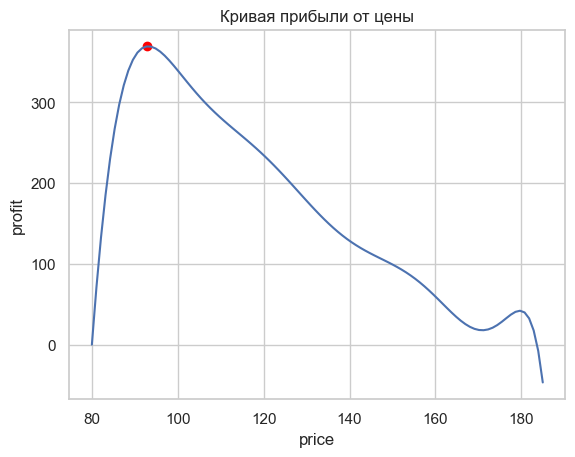

считаем оптимальную цену 14 дней


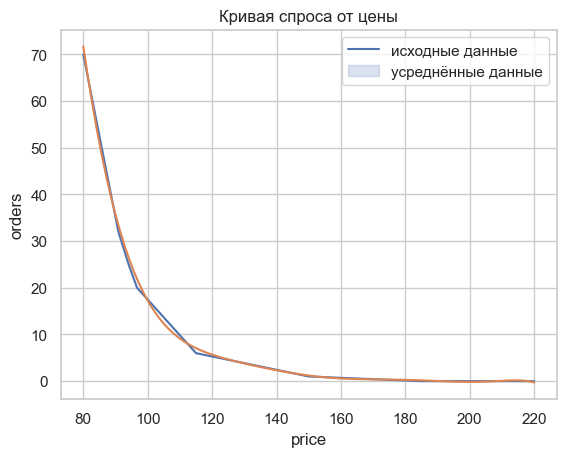

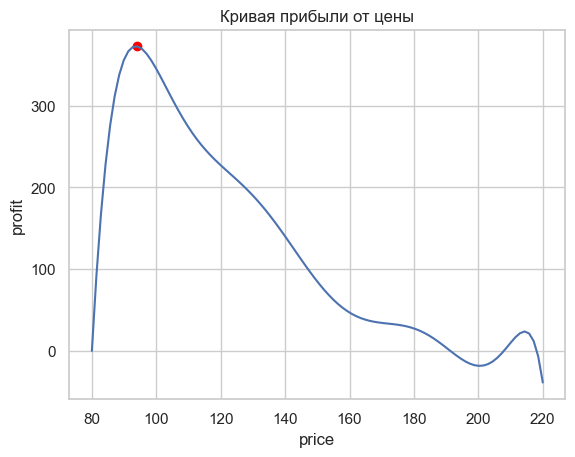


--------------------------

сегодня: 2023-08-14 
данные предыдущего периода:


,date,orders,price,profit,elasticity
2,2023-08-07,0,185.00,97.86,False
3,2023-08-08,70,80.00,0.00,False
4,2023-08-09,1,150.00,78.08,False
5,2023-08-10,20,96.69,343.92,True
6,2023-08-11,25,94.07,353.39,True
7,2023-08-12,32,90.89,355.51,True
8,2023-08-13,23,94.99,352.32,True


считаем оптимальную цену 7 дней


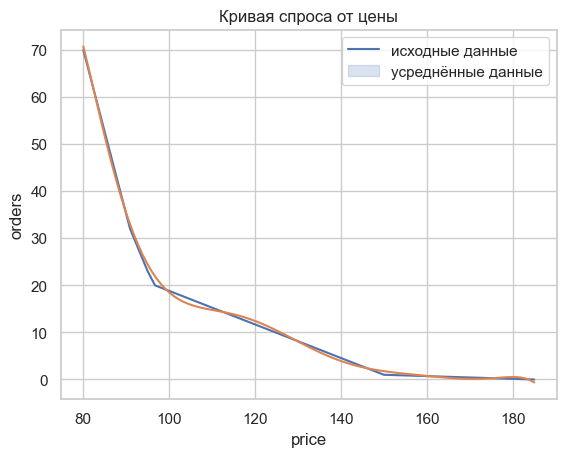

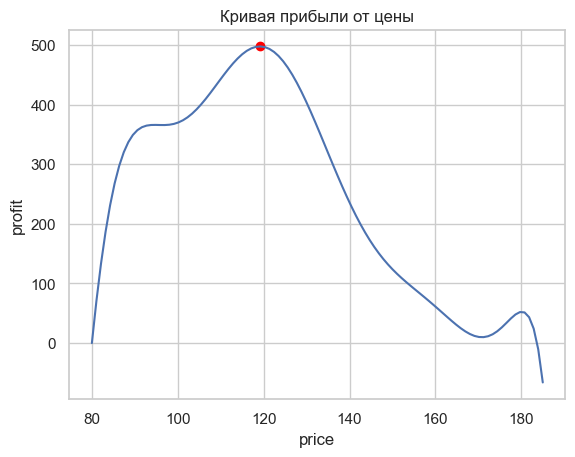

считаем оптимальную цену 14 дней


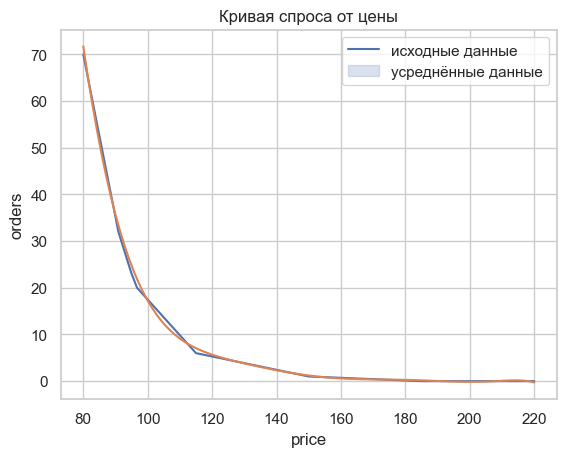

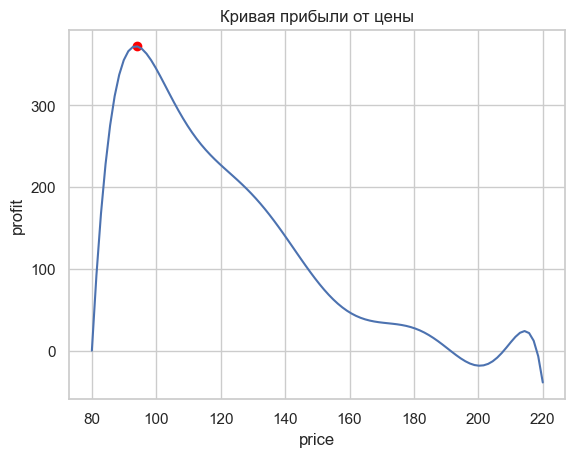


--------------------------

сегодня: 2023-08-15 
данные предыдущего периода:


,date,orders,price,profit,elasticity
3,2023-08-08,70,80.00,0.00,False
4,2023-08-09,1,150.00,78.08,False
5,2023-08-10,20,96.69,343.92,True
6,2023-08-11,25,94.07,353.39,True
7,2023-08-12,32,90.89,355.51,True
8,2023-08-13,23,94.99,352.32,True
9,2023-08-14,10,105.38,269.71,True


считаем оптимальную цену 7 дней


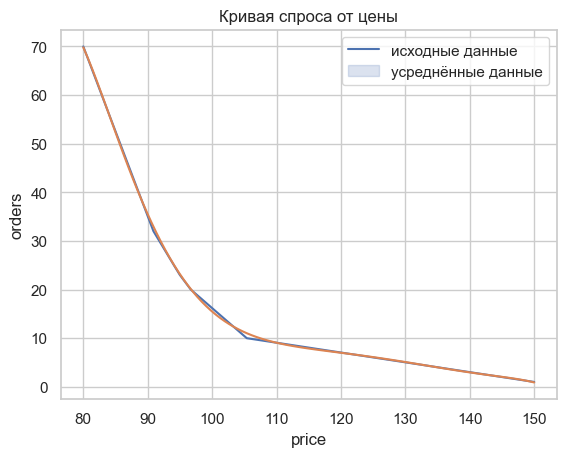

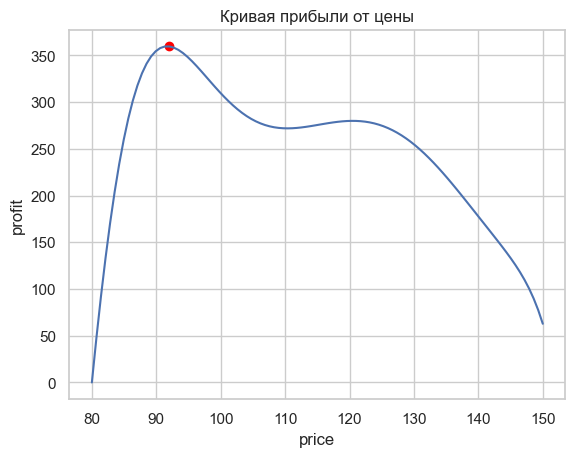

считаем оптимальную цену 14 дней


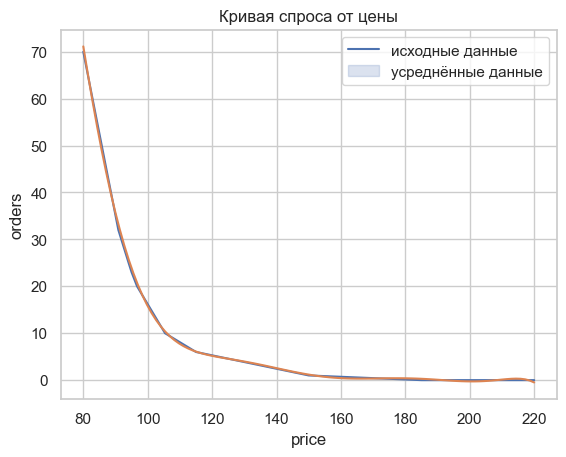

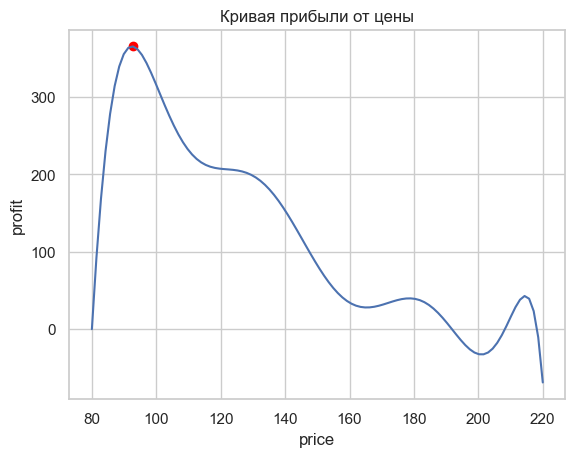


--------------------------

сегодня: 2023-08-16 
данные предыдущего периода:


,date,orders,price,profit,elasticity
4,2023-08-09,1,150.00,78.08,False
5,2023-08-10,20,96.69,343.92,True
6,2023-08-11,25,94.07,353.39,True
7,2023-08-12,32,90.89,355.51,True
8,2023-08-13,23,94.99,352.32,True
9,2023-08-14,10,105.38,269.71,True
10,2023-08-15,32,90.99,358.77,True


считаем оптимальную цену 7 дней


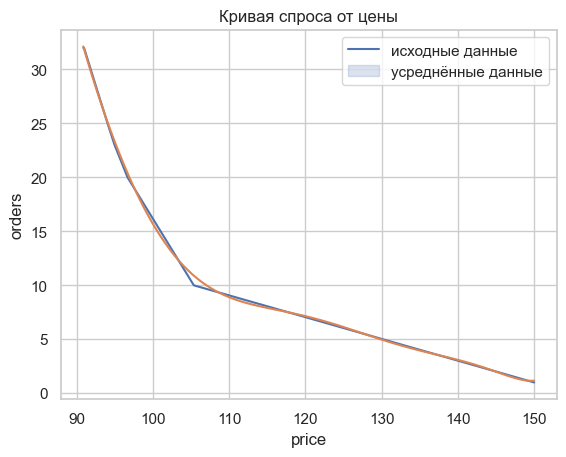

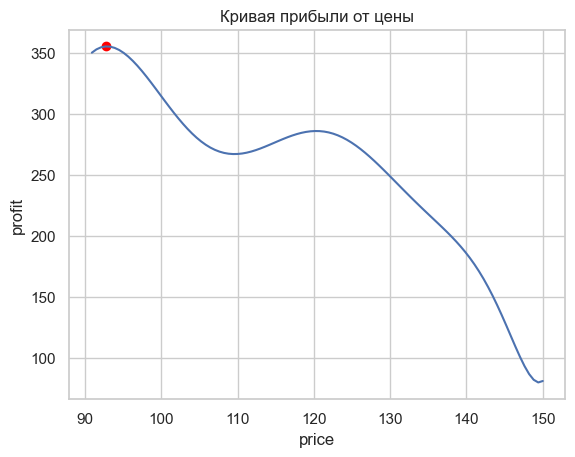

считаем оптимальную цену 14 дней


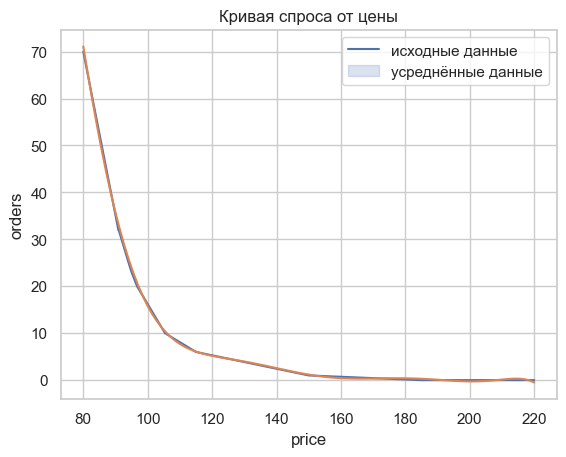

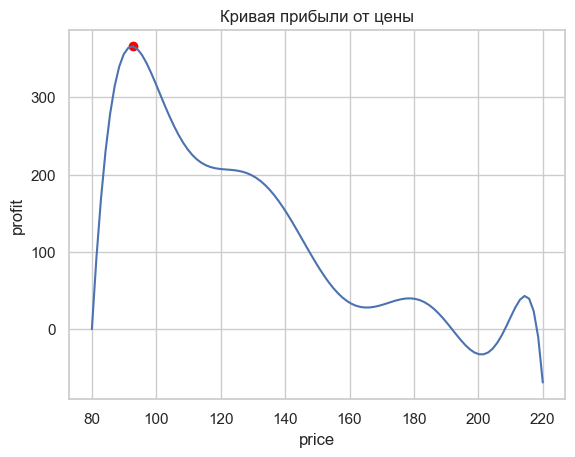


--------------------------

сегодня: 2023-08-17 
данные предыдущего периода:


,date,orders,price,profit,elasticity
5,2023-08-10,20,96.69,343.92,True
6,2023-08-11,25,94.07,353.39,True
7,2023-08-12,32,90.89,355.51,True
8,2023-08-13,23,94.99,352.32,True
9,2023-08-14,10,105.38,269.71,True
10,2023-08-15,32,90.99,358.77,True
11,2023-08-16,26,93.22,354.72,True


считаем оптимальную цену 7 дней


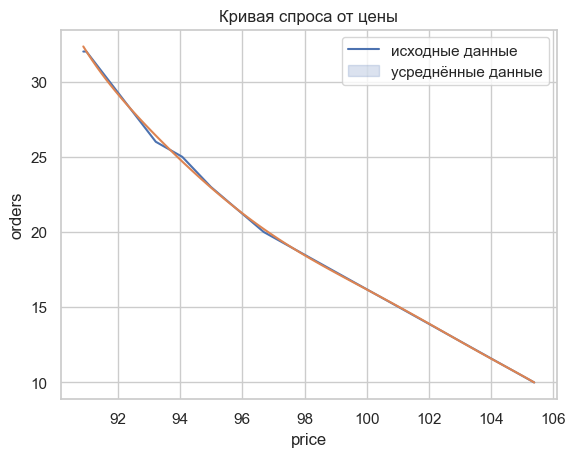

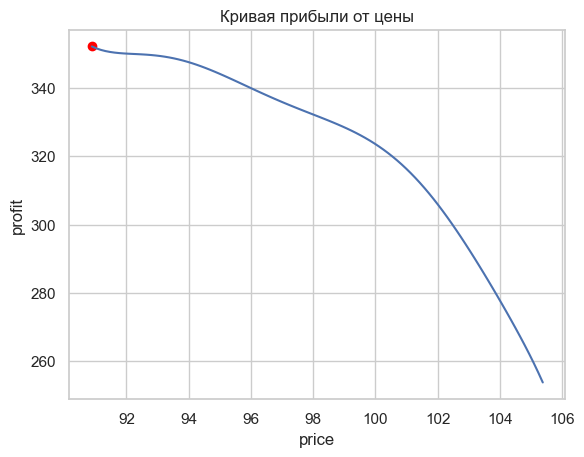

считаем оптимальную цену 14 дней


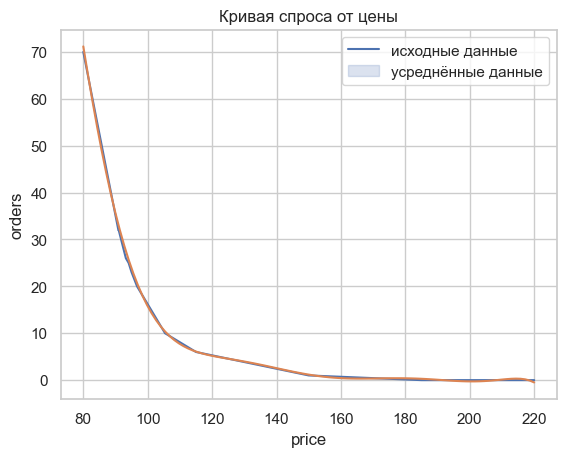

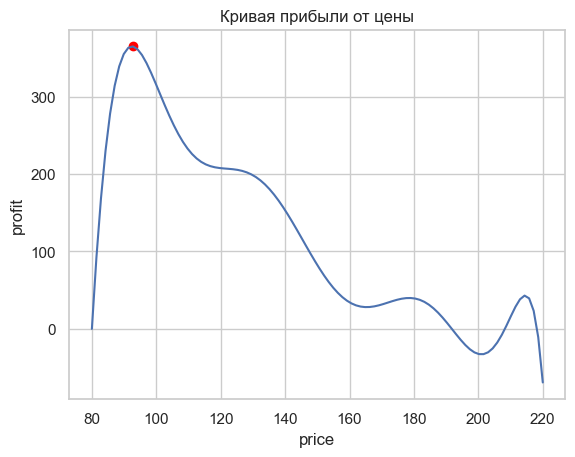


--------------------------

сегодня: 2023-08-18 
данные предыдущего периода:


,date,orders,price,profit,elasticity
6,2023-08-11,25,94.07,353.39,True
7,2023-08-12,32,90.89,355.51,True
8,2023-08-13,23,94.99,352.32,True
9,2023-08-14,10,105.38,269.71,True
10,2023-08-15,32,90.99,358.77,True
11,2023-08-16,26,93.22,354.72,True
12,2023-08-17,34,90.01,348.45,True


считаем оптимальную цену 7 дней


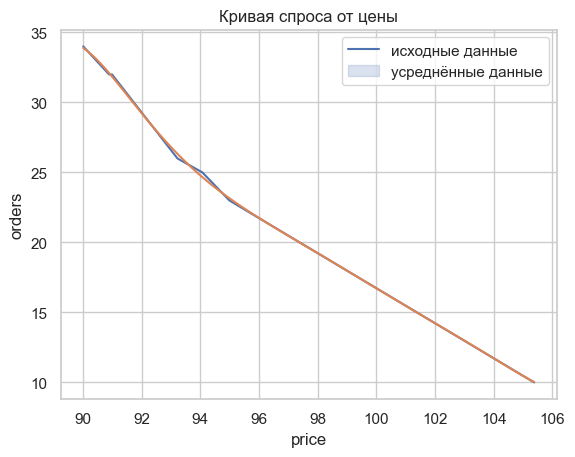

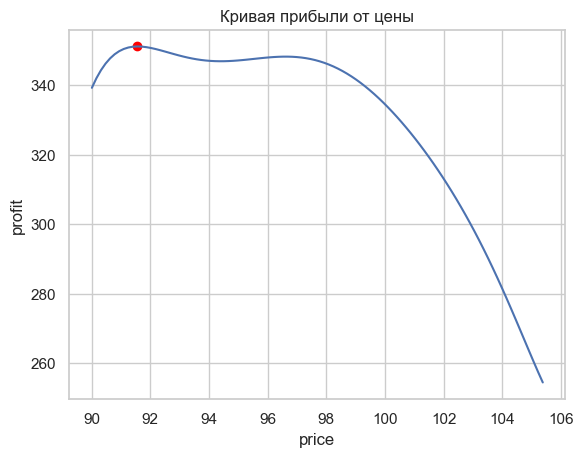

считаем оптимальную цену 14 дней


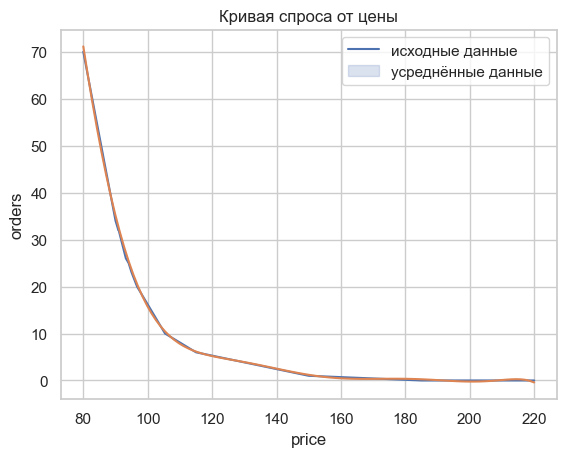

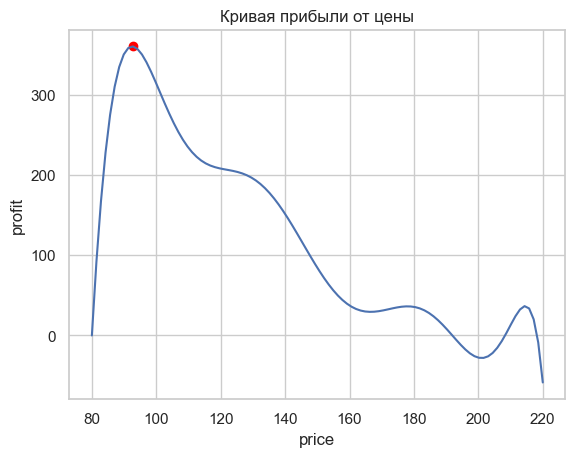


--------------------------

сегодня: 2023-08-19 
данные предыдущего периода:


,date,orders,price,profit,elasticity
7,2023-08-12,32,90.89,355.51,True
8,2023-08-13,23,94.99,352.32,True
9,2023-08-14,10,105.38,269.71,True
10,2023-08-15,32,90.99,358.77,True
11,2023-08-16,26,93.22,354.72,True
12,2023-08-17,34,90.01,348.45,True
13,2023-08-18,25,93.81,346.66,True


считаем оптимальную цену 7 дней


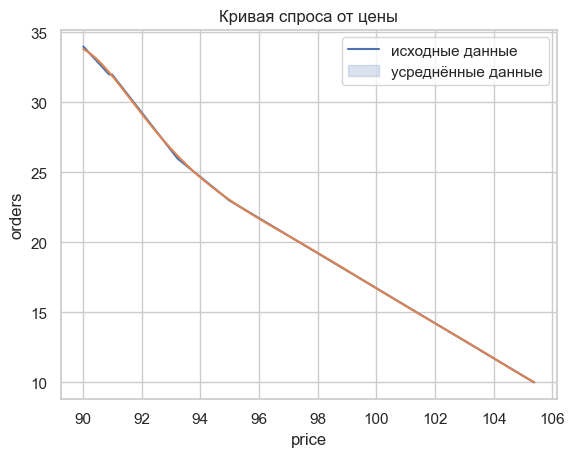

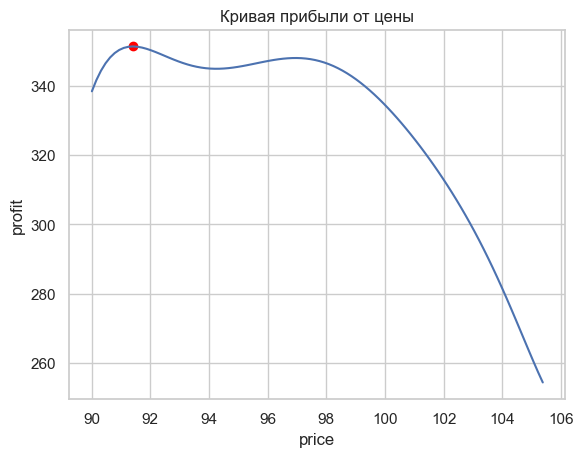

считаем оптимальную цену 14 дней


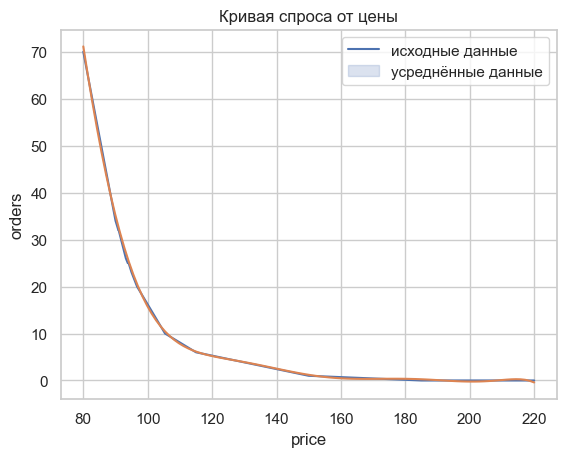

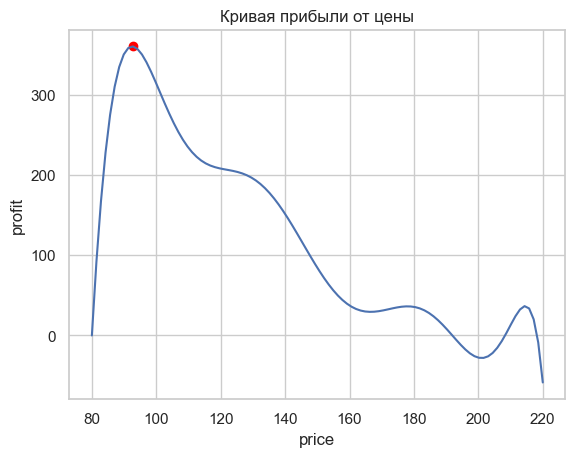


--------------------------

сегодня: 2023-08-20 
данные предыдущего периода:


,date,orders,price,profit,elasticity
8,2023-08-13,23,94.99,352.32,True
9,2023-08-14,10,105.38,269.71,True
10,2023-08-15,32,90.99,358.77,True
11,2023-08-16,26,93.22,354.72,True
12,2023-08-17,34,90.01,348.45,True
13,2023-08-18,25,93.81,346.66,True
14,2023-08-19,30,91.83,361.93,True


считаем оптимальную цену 7 дней


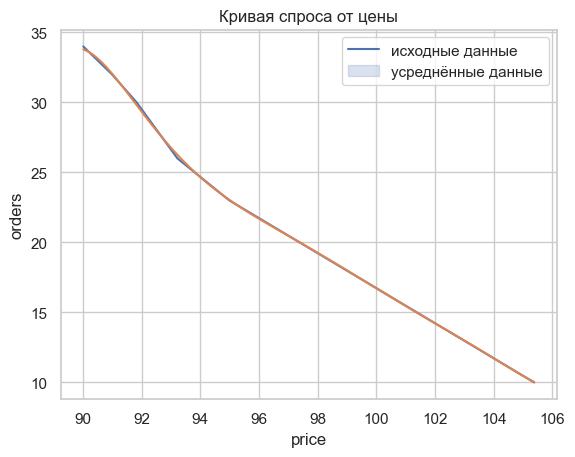

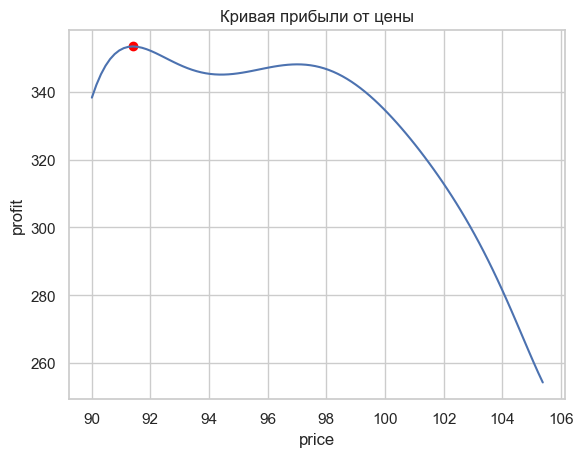

считаем оптимальную цену 14 дней


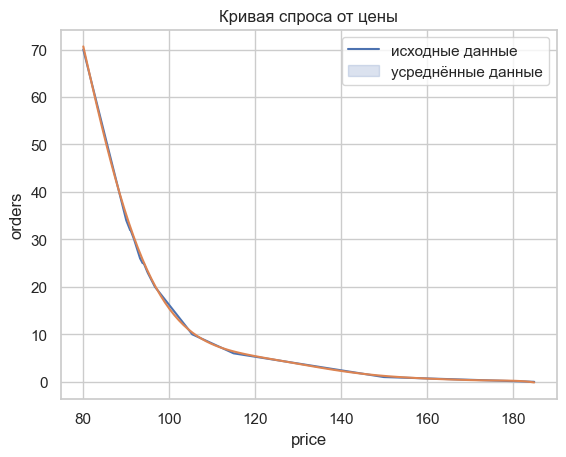

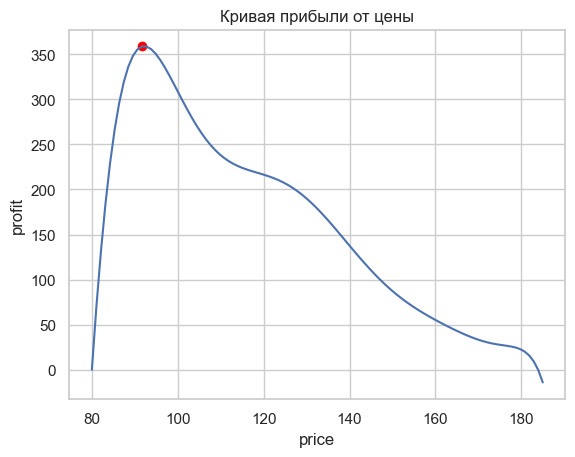


--------------------------

сегодня: 2023-08-21 
данные предыдущего периода:


,date,orders,price,profit,elasticity
9,2023-08-14,10,105.38,269.71,True
10,2023-08-15,32,90.99,358.77,True
11,2023-08-16,26,93.22,354.72,True
12,2023-08-17,34,90.01,348.45,True
13,2023-08-18,25,93.81,346.66,True
14,2023-08-19,30,91.83,361.93,True
15,2023-08-20,32,90.95,357.22,True


считаем оптимальную цену 7 дней


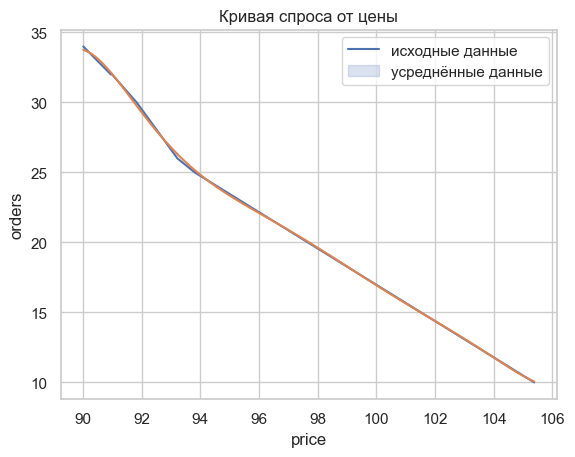

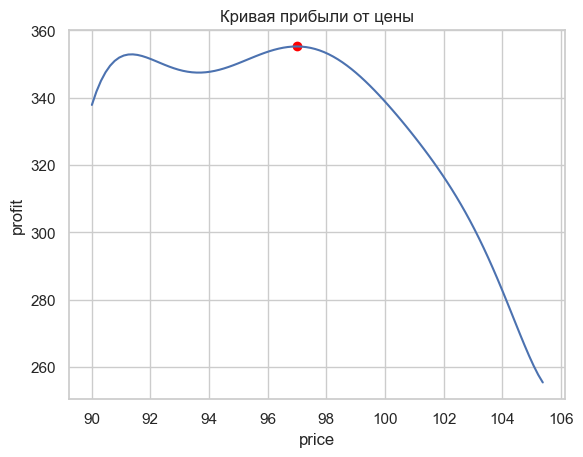

считаем оптимальную цену 14 дней


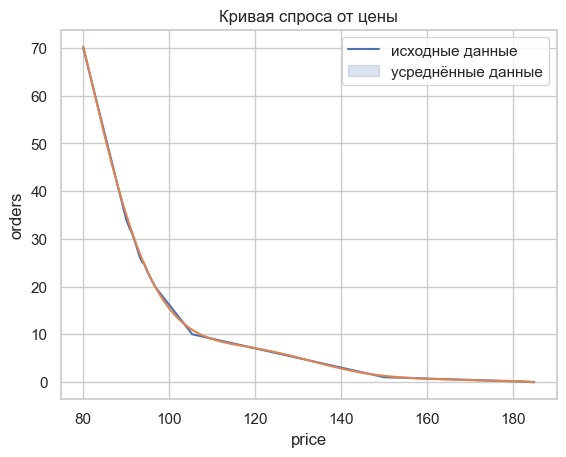

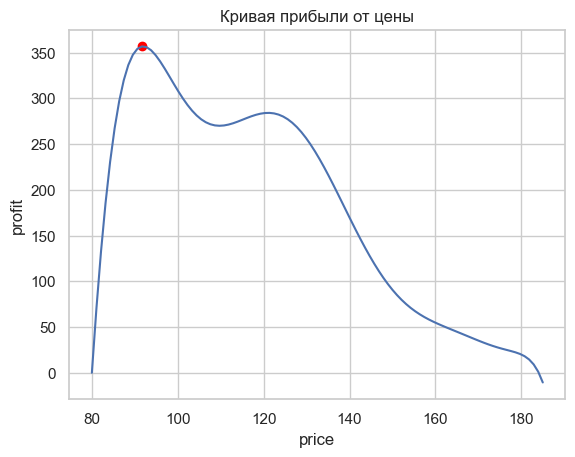


--------------------------

сегодня: 2023-08-22 
данные предыдущего периода:


,date,orders,price,profit,elasticity
10,2023-08-15,32,90.99,358.77,True
11,2023-08-16,26,93.22,354.72,True
12,2023-08-17,34,90.01,348.45,True
13,2023-08-18,25,93.81,346.66,True
14,2023-08-19,30,91.83,361.93,True
15,2023-08-20,32,90.95,357.22,True
16,2023-08-21,20,96.18,333.36,True


считаем оптимальную цену 7 дней


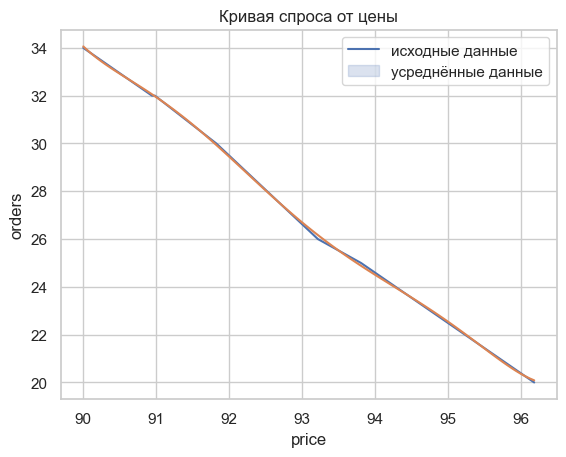

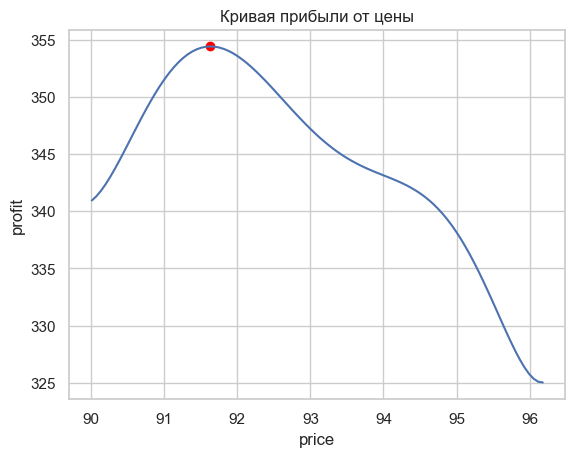

считаем оптимальную цену 14 дней


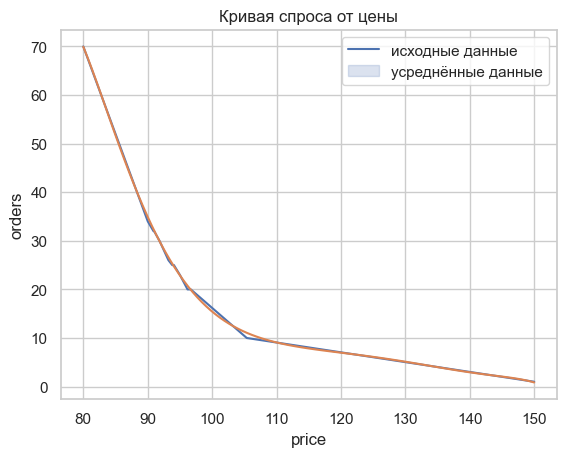

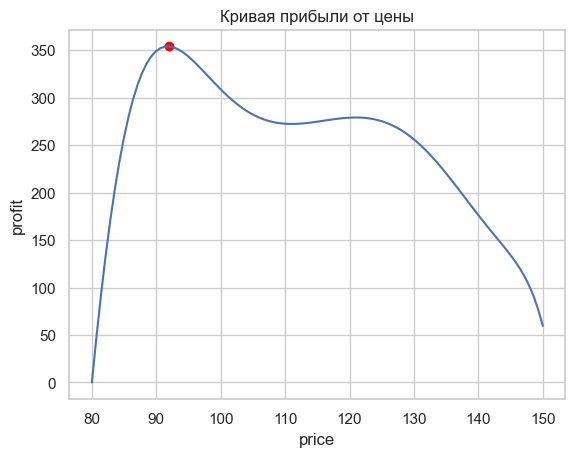


--------------------------

сегодня: 2023-08-23 
данные предыдущего периода:


,date,orders,price,profit,elasticity
11,2023-08-16,26,93.22,354.72,True
12,2023-08-17,34,90.01,348.45,True
13,2023-08-18,25,93.81,346.66,True
14,2023-08-19,30,91.83,361.93,True
15,2023-08-20,32,90.95,357.22,True
16,2023-08-21,20,96.18,333.36,True
17,2023-08-22,28,92.40,355.28,True


считаем оптимальную цену 7 дней


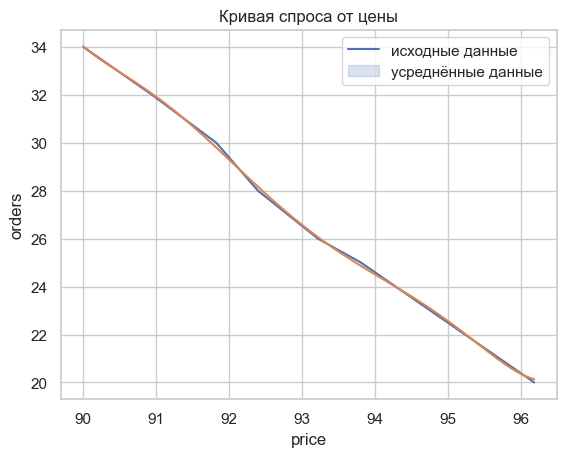

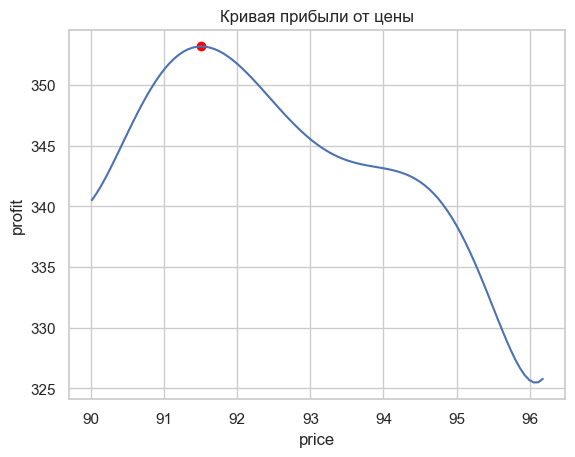

считаем оптимальную цену 14 дней


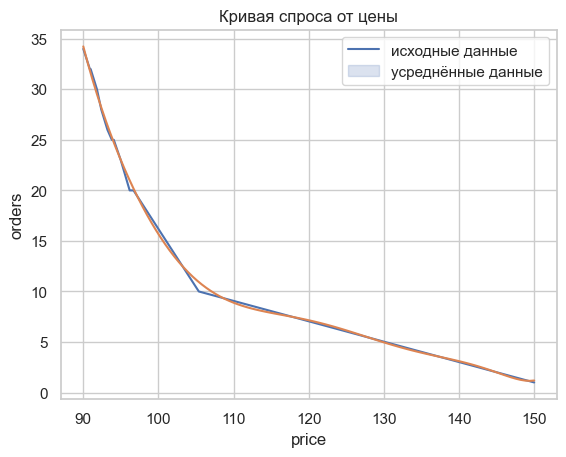

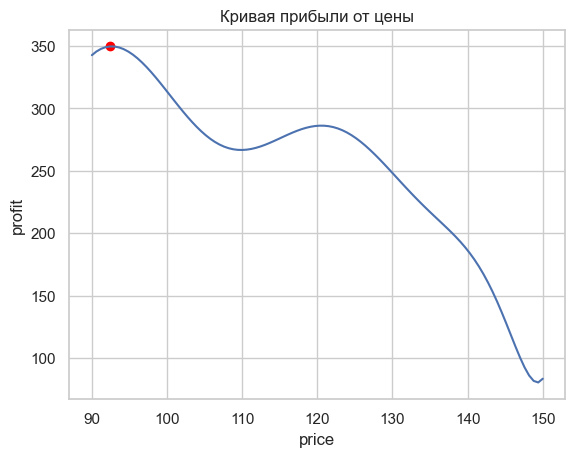


--------------------------

сегодня: 2023-08-24 
данные предыдущего периода:


,date,orders,price,profit,elasticity
12,2023-08-17,34,90.01,348.45,True
13,2023-08-18,25,93.81,346.66,True
14,2023-08-19,30,91.83,361.93,True
15,2023-08-20,32,90.95,357.22,True
16,2023-08-21,20,96.18,333.36,True
17,2023-08-22,28,92.40,355.28,True
18,2023-08-23,28,92.72,364.27,True


считаем оптимальную цену 7 дней


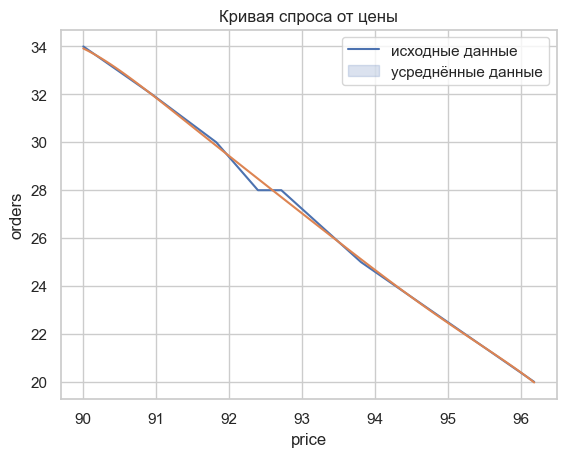

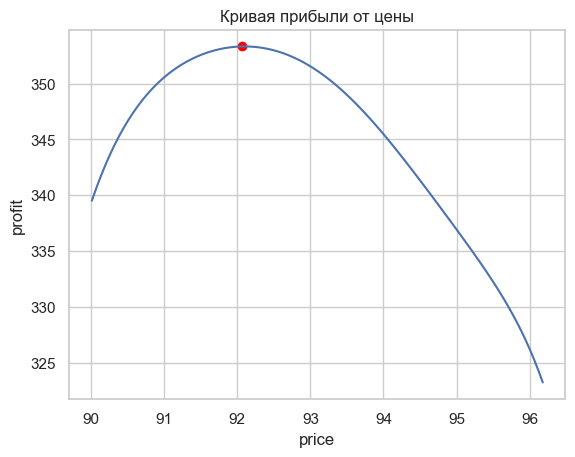

считаем оптимальную цену 14 дней


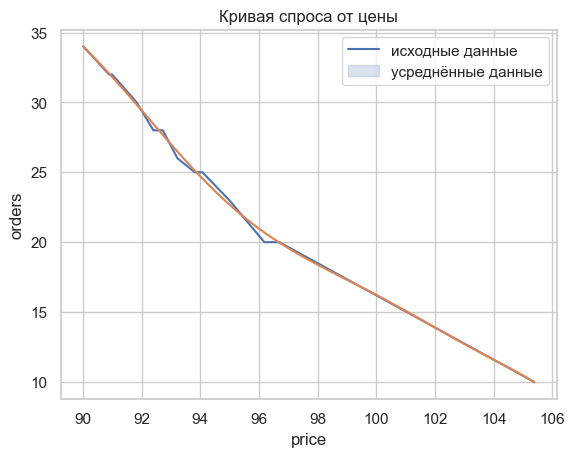

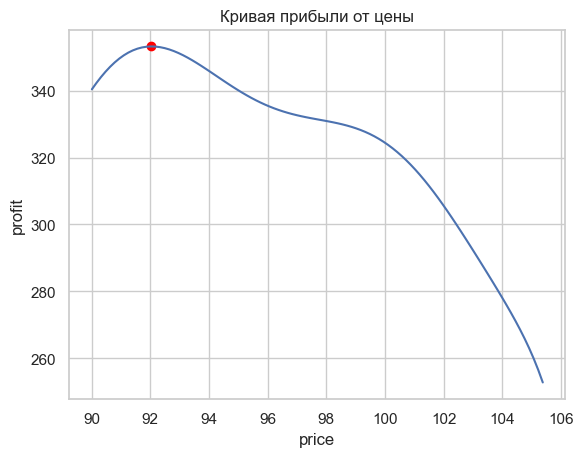


--------------------------

сегодня: 2023-08-25 
данные предыдущего периода:


,date,orders,price,profit,elasticity
13,2023-08-18,25,93.81,346.66,True
14,2023-08-19,30,91.83,361.93,True
15,2023-08-20,32,90.95,357.22,True
16,2023-08-21,20,96.18,333.36,True
17,2023-08-22,28,92.40,355.28,True
18,2023-08-23,28,92.72,364.27,True
19,2023-08-24,34,90.28,357.81,True


считаем оптимальную цену 7 дней


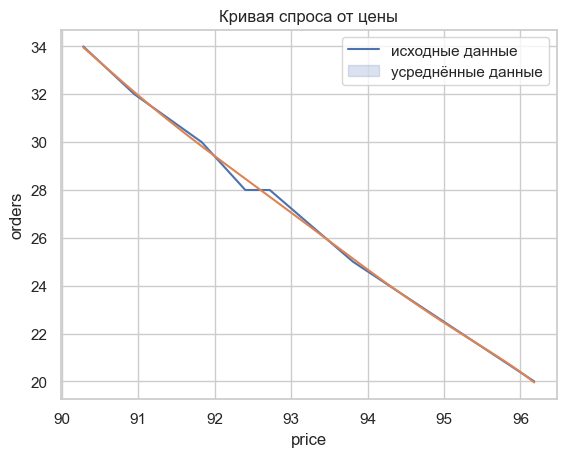

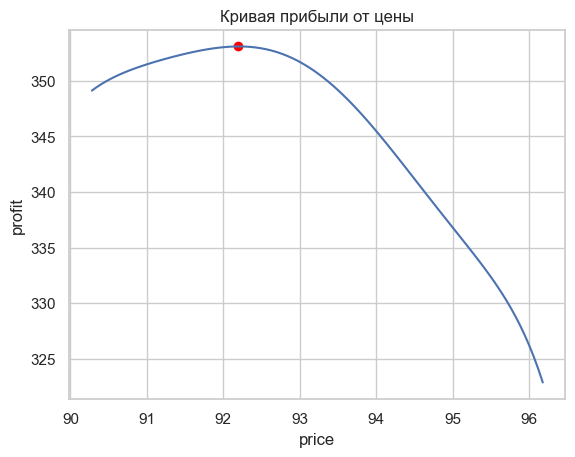

считаем оптимальную цену 14 дней


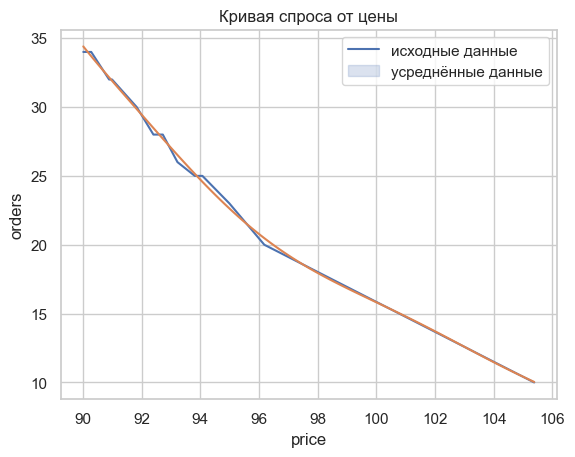

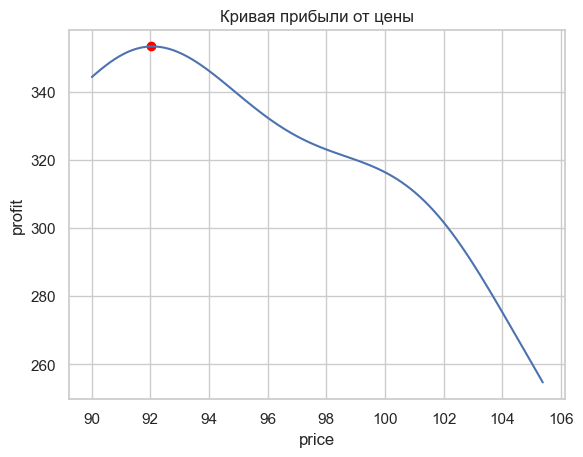


--------------------------



In [1068]:
# создаём датафрейм для сбора данных
data = pd.DataFrame({'date': [], 'orders': [], 'price':[], 'profit': [], 'elasticity': []})

# запустим генерацию данных
for day in range(days):
    
    # определяем сегодняшнее число
    today = date_start + pd.Timedelta(days=day)
    print('сегодня:', today.strftime('%Y-%m-%d'), '\nданные предыдущего периода:')
    
    # получаем последние заказы за 7 и 14 дней
    last_orders_7 = get_last_orders(data, last_days=7)
    last_orders_14 = get_last_orders(data, last_days=14)
    display(last_orders_7)
    
    # выясняем можем ли мы сегодня рассчитать оптимальную цену из накопленных данных
    premission = get_premission_elasticity(last_orders_7)
    
    # получаем цену, если накопленных данных не достаточно, берём цену из списка цен для первичного тестирования эластичности
    if premission:
        print('считаем оптимальную цену 7 дней')
        price_7 = get_elast(last_orders_7[['orders', 'price']], cost_price, smoth=8, show_data=False, chart=True)[0]
        print('считаем оптимальную цену 14 дней')
        price_14 = get_elast(last_orders_14[['orders', 'price']], cost_price, smoth=8, show_data=False, chart=True)[0]
        price = (price_7 + price_14) / 2
        # чтобы мы постоянно проверяли изменение эластичности
        price = random.uniform(price*0.98, price*1.02)
    else:
        print('данных для расчёта оптимальной цены НЕ достаточно')
        primary = get_primary_price(list_prices, last_ind_list_prices)
        price = primary[0]
        
        # сохраняем индекс для последующих запросов
        last_ind_list_prices = primary[1]
        
    # получаем количество заказов сегодня исходя из цены
    orders = get_count_orders(df, price)
    
    # считаем прибыль
    profit = (price - cost_price) * orders
    
    # записываем сегодняшний результат
    data.loc[len(data.index)] = [today, int(orders), round(price, 2), round(profit, 2), premission]
    print('\n--------------------------\n')

<hr>

### Результаты
В итоге мы получили такой набор данных:

In [1069]:
data

,date,orders,price,profit,elasticity
0,2023-08-05,0,220.00,130.48,False
1,2023-08-06,6,115.00,217.54,False
2,2023-08-07,0,185.00,97.86,False
3,2023-08-08,70,80.00,0.00,False
4,2023-08-09,1,150.00,78.08,False
5,2023-08-10,20,96.69,343.92,True
6,2023-08-11,25,94.07,353.39,True
7,2023-08-12,32,90.89,355.51,True
8,2023-08-13,23,94.99,352.32,True
9,2023-08-14,10,105.38,269.71,True


Пtрвые пять строк колонки elasticity имеют значение False, это значит что мы не использовали оптимизацию подбора цены а прощупывали (набирали достаточное количество) данные.  

На графиках ниже видно что этот период имеет резкие скачки изменения цены и не лучшие показатели по размеру прибыли.

Размер средней прибыли  в день 349
Средняя цена товара 93.27


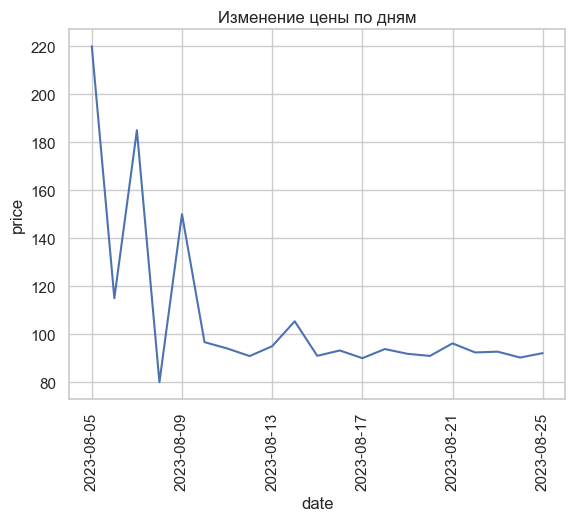

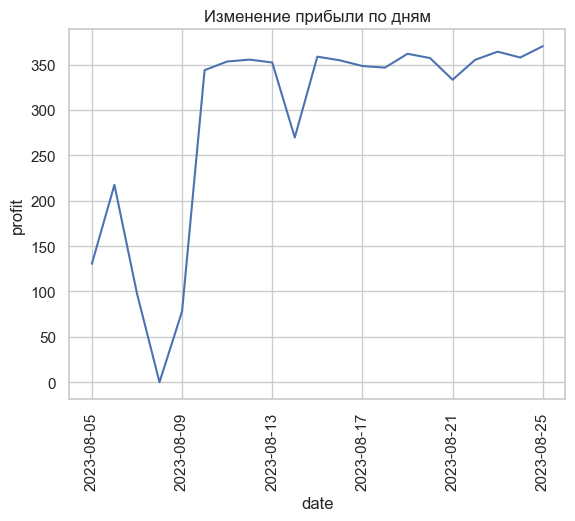

In [1070]:
print('Размер средней прибыли  в день', round(data.tail(14).profit.mean()))
print('Средняя цена товара', round(data.tail(14).price.mean(), 2))

sns.lineplot(data, x='date', y='price')
plt.title('Изменение цены по дням')
plt.xticks(rotation = 90)
plt.show();

sns.lineplot(data, x='date', y='profit')
plt.title('Изменение прибыли по дням')
plt.xticks(rotation = 90)
plt.show();

Мы получили близкий к ожидаемому результат на 6 день